In [27]:
import pandas as pd
import numpy as np
import os, re, pickle as pkl
%matplotlib inline
import matplotlib.pyplot as plt
from collections import Counter
import random

from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras import Input, Model, layers, optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

In [2]:
train_df = pd.read_csv(os.path.join('../data', 'train.csv'))
valid_df = pd.read_csv(os.path.join('../data', 'valid.csv'))
test_df = pd.read_csv(os.path.join('../data', 'test.csv'))
labels = open(os.path.join('../data', 'labels.txt'), 'r').read().splitlines()

train_df.tail()

,Unnamed: 0,description,place,charged_amount,label,label_id
8273,8427,Bypass of diseased or blocked artery (aorta to...,F,6287.77,Very-High,5
8274,8436,Removal of thyroid and surrounding lymph nodes,F,4779.93,Very-High,5
8275,8446,Cesarean delivery with pre- and post-delivery ...,F,4933.34,Very-High,5
8276,8451,Removal of growth of external ear through mast...,F,5864.21,Very-High,5
8277,8467,Reconstruction of upper eyelid by transfer of ...,F,4726.36,Very-High,5


In [3]:
def clean_text(rsd):
    rsd = str(rsd).lower()
    tokens = re.split('\W+', rsd)
    return tokens

train_df['desc_clean'] = train_df['description'].apply(clean_text)
valid_df['desc_clean'] = valid_df['description'].apply(clean_text)
test_df['desc_clean'] = test_df['description'].apply(clean_text)

In [4]:
train_df['desc_clean'][10]

['nuclear', 'medicine', 'study', 'of', 'salivary', 'gland']

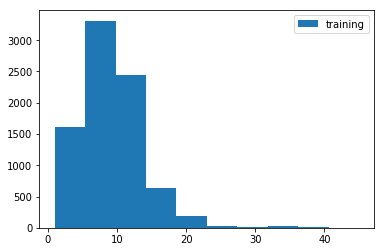

In [5]:
plt.hist(train_df.desc_clean.apply(len).values, label="training")
plt.legend()

In [6]:
print("Average Description Length: {}\nVariance: {}".format(np.mean(list(map(len, train_df.desc_clean.values))),
                                     np.var(list(map(len, train_df.desc_clean.values)))))

Average Description Length: 9.233027301280503
Variance: 20.76219984728557


95% Unigram Count Threshold: 1809


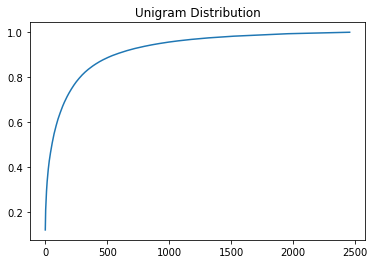

In [7]:
thresh = 0.95

train_cnt = Counter()
for desc in train_df['desc_clean']:
    for token in desc:
        train_cnt[token] += 1
        
_, tok_cts = zip(*train_cnt.most_common())
plt.title('Unigram Distribution')
plt.plot(np.cumsum(tok_cts)/np.sum(tok_cts))
max_vocab = np.where((np.cumsum(tok_cts)/np.sum(tok_cts)) > 0.99)[0][0]
print("{}% Unigram Count Threshold: {}".format(int(thresh*100), max_vocab))

In [10]:
desc_length = 20
batch_size = 128
vocab_size = max_vocab

tokenizer = Tokenizer(oov_token = None, num_words = vocab_size)
tokenizer.fit_on_texts(train_df.desc_clean)
pkl.dump(tokenizer, open('tokenizer.pkl', "wb"))

In [15]:
import math

def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

class DataGenerator:
    def __init__(self, manifest_df, description_length, num_classes,
                 tokenizer = None, augmenter = None, 
                 batch_size=batch_size,shuffle=True):
        
        self.manifest_df = manifest_df.copy(deep=True).reset_index(drop=True)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.tokenizer = tokenizer
        self.descriptions = self.manifest_df.description.values
        self.num_classes = num_classes
        self.augmenter = augmenter
        self.batch_desc = sequence.pad_sequences(self.tokenizer.texts_to_sequences([str(k).lower() for k in self.descriptions]),
                    maxlen=description_length,
                    dtype=int,
                    padding='post',
                    truncating='post',
                    value=0
                )
        
    @property
    def steps_per_epoch(self):
        return int(math.ceil(len(self.manifest_df)/self.batch_size))
    
    def _augment(self, rsds):
        return [self.augmenter.augment(rsd) for rsd in rsds]
    
    def flow_X(self):
        while True:
            idx = list(range(len(self.manifest_df)))
            if self.shuffle:
                random.shuffle(idx)

            for bidx in batch(idx, self.batch_size):
                batch_desc = self.batch_desc[bidx]
                 
                x = {'desc_input': batch_desc}
                
                yield x
    
    def flow(self):
        while True:
            idx = list(range(len(self.manifest_df)))
            if self.shuffle:
                random.shuffle(idx)

            for bidx in batch(idx, self.batch_size):
                labels = self.manifest_df.iloc[bidx]['label_id'].values
                batch_desc = self.batch_desc[bidx]
                
                x = {'desc_input': batch_desc }
                
                y = np.asarray(labels, dtype=np.int32)
                
                yield x, y

In [16]:
train_gen = DataGenerator(train_df, desc_length, len(labels),
                             tokenizer = tokenizer)
valid_gen = DataGenerator(valid_df, desc_length, len(labels),
                             tokenizer = tokenizer)

In [19]:
num_classes = len(labels)
embedding_size = 128
learning_rate = 0.001
lstm_size = 128

def lstm_model(num_classes, embedding_size, learning_rate, lstm_size):
    desc_input = Input(shape=(desc_length,), name='desc_input')
    
    embedding = layers.Embedding(
        vocab_size,
        embedding_size,
        input_length= desc_length,
        mask_zero=True,
        embeddings_initializer='truncated_normal'
    )(desc_input)
    
    lstm = layers.LSTM(lstm_size)(embedding)
    logits = layers.Dense(num_classes)(lstm)
    predictions = layers.Activation(activation='softmax')(logits)

    model = Model(inputs=[desc_input], outputs=[predictions])
    return model

lstm_model = lstm_model(num_classes, embedding_size, learning_rate, lstm_size)
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
desc_input (InputLayer)      (None, 20)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 20, 128)           231552    
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 774       
_________________________________________________________________
activation_2 (Activation)    (None, 6)                 0         
Total params: 363,910
Trainable params: 363,910
Non-trainable params: 0
_________________________________________________________________


In [22]:
from keras.utils import multi_gpu_model

parallel_model = multi_gpu_model(lstm_model, 8)

In [23]:
parallel_model.compile(
        loss = 'sparse_categorical_crossentropy',
        metrics = ['accuracy'],
        optimizer = optimizers.Adam(lr=learning_rate),
    )

In [28]:
epochs = 30
patience = 5
model_path = ('model.h5')

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=patience,
)
checkpoint = ModelCheckpoint(
    model_path, 
    monitor='val_loss',
    save_best_only=True,
)

logger = CSVLogger('training.log')

print('Beginning training')
parallel_model.fit_generator(train_gen.flow(), validation_data=valid_gen.flow(),
                    steps_per_epoch=train_gen.steps_per_epoch, 
                    validation_steps=valid_gen.steps_per_epoch,
                    callbacks=[early_stopping, checkpoint, logger],
                    epochs=epochs)

Beginning training
Epoch 1/30
65/65 [==============================] - 25s 382ms/step - loss: 1.5291 - acc: 0.3934 - val_loss: 1.2327 - val_acc: 0.5193
Epoch 2/30
65/65 [==============================] - 5s 84ms/step - loss: 1.0649 - acc: 0.5782 - val_loss: 1.0692 - val_acc: 0.5522
Epoch 3/30
65/65 [==============================] - 6s 87ms/step - loss: 0.9153 - acc: 0.6278 - val_loss: 1.0100 - val_acc: 0.5783
Epoch 4/30
65/65 [==============================] - 5s 84ms/step - loss: 0.8314 - acc: 0.6630 - val_loss: 0.9763 - val_acc: 0.5924
Epoch 5/30
65/65 [==============================] - 6s 85ms/step - loss: 0.7784 - acc: 0.6832 - val_loss: 0.9599 - val_acc: 0.6141
Epoch 6/30
65/65 [==============================] - 5s 85ms/step - loss: 0.7288 - acc: 0.7063 - val_loss: 0.9537 - val_acc: 0.6088
Epoch 7/30
65/65 [==============================] - 5s 84ms/step - loss: 0.6919 - acc: 0.7250 - val_loss: 0.9620 - val_acc: 0.6320
Epoch 8/30
65/65 [==============================] - 6s 85ms/st

In [31]:
test_gen = DataGenerator(test_df, desc_length, len(labels),
                             tokenizer = tokenizer, shuffle=False)
test_y_pred_raw = parallel_model.predict_generator(test_gen.flow_X(), steps = test_gen.steps_per_epoch, verbose=1)

27/27 [==============================] - 2s 62ms/step


In [34]:
y_pred = np.argmax(test_y_pred_raw, axis=-1)
y_conf = np.asarray([test_y_pred_raw[i,p] for i,p in enumerate(y_pred)])
y_pred_labels = [labels[i] for i in y_pred]

pd.DataFrame({
    'description': test_df.description.values,
    'y_pred':y_pred_labels,
    'y_conf': y_conf,
    'y_true':test_df.label.values
}).to_csv('results.csv', index=False)